# Import data, compute features, train-val split, feature selection, pre-process, & save
## Import
### Modules

In [27]:
from __future__ import division
%matplotlib inline
import sys
sys.path.append('./Modules/')
from Basics import *
from ML_Tools.General.Feature_Selection import *

### Data

In [9]:
data = pandas.read_csv(dirLoc + 'training.csv')

In [10]:
data.rename(index=str, columns={"Weight": "gen_weight"}, inplace=True)

In [11]:
data['gen_target'] = 0
data.loc[data.Label == 's', 'gen_target'] = 1

In [14]:
data.drop(columns=['Label', 'EventId'], inplace=True)

In [15]:
data.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,gen_weight,gen_target
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,1
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,0
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,0
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,0
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,0


In [19]:
print [x for x in data.columns], len(data.columns)

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'gen_weight', 'gen_target'] 32


## Feature processing

## Train-Validation Split

In [25]:
trainIndeces, valIndeces = splitDevVal(data)
train = data.loc[trainIndeces]
val = data.loc[valIndeces]
print len(train), len(val)

200000 50000


''''data.loc[trainIndeces].to_csv(dirLoc + 'train.csv')
data.loc[valIndeces].to_csv(dirLoc + 'val.csv')''''

## Feature Selection
### Get important features

In [30]:
trainFeatures = [x for x in train.columns if 'gen' not in x]
print len(trainFeatures)

30


In [31]:
%%time
importantFeatures = rankClassifierFeatures(train, trainFeatures)

Running fold 1 /10
ROC AUC: 0.89642
Running fold 2 /10
ROC AUC: 0.89635
Running fold 3 /10
ROC AUC: 0.89887
Running fold 4 /10
ROC AUC: 0.89888
Running fold 5 /10
ROC AUC: 0.90022
Running fold 6 /10
ROC AUC: 0.90069
Running fold 7 /10
ROC AUC: 0.89730
Running fold 8 /10
ROC AUC: 0.90549
Running fold 9 /10
ROC AUC: 0.89778
Running fold 10 /10
ROC AUC: 0.89945
30 important features identified
Feature	Importance
---------------------
DER_mass_MMC 	0.1657142847776413
DER_mass_transverse_met_lep 	0.10457142814993858
DER_mass_vis 	0.08485714420676231
PRI_tau_pt 	0.07714285776019096
DER_deltar_tau_lep 	0.0712857149541378
PRI_jet_leading_eta 	0.054714285582304
PRI_lep_eta 	0.051571428775787354
PRI_tau_eta 	0.0515714280307293
DER_lep_eta_centrality 	0.04671428613364696
DER_mass_jet_jet 	0.04157142862677574
DER_deltaeta_jet_jet 	0.030428571440279484
DER_pt_tot 	0.029714285396039486
DER_met_phi_centrality 	0.029428571090102197
PRI_jet_num 	0.02571428529918194
PRI_met 	0.02442857138812542
DER_pt_h

In [32]:
print importantFeatures[0]

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'PRI_tau_pt', 'DER_deltar_tau_lep', 'PRI_jet_leading_eta', 'PRI_lep_eta', 'PRI_tau_eta', 'DER_lep_eta_centrality', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 'DER_pt_tot', 'DER_met_phi_centrality', 'PRI_jet_num', 'PRI_met', 'DER_pt_h', 'DER_pt_ratio_lep_tau', 'DER_sum_pt', 'PRI_jet_leading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_all_pt', 'PRI_met_sumet', 'DER_prodeta_jet_jet', 'PRI_lep_pt', 'PRI_jet_subleading_pt', 'PRI_met_phi', 'PRI_jet_leading_phi', 'PRI_lep_phi', 'PRI_jet_subleading_phi', 'PRI_tau_phi']


###  Check correlations

In [35]:
sig = (train.gen_target == 1)
bkg = (train.gen_target == 0)

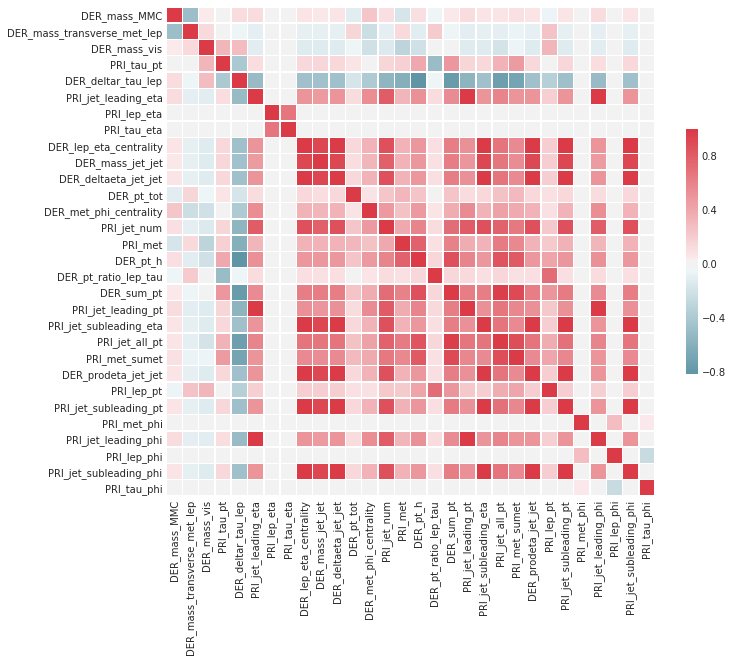

In [36]:
getCorrMat(train[sig][importantFeatures[0]])

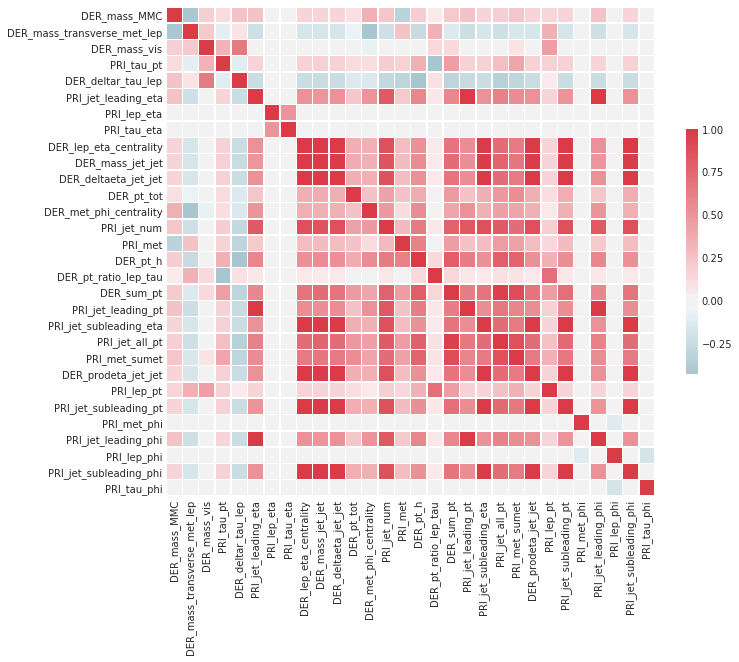

In [37]:
getCorrMat(train[bkg][importantFeatures[0]])

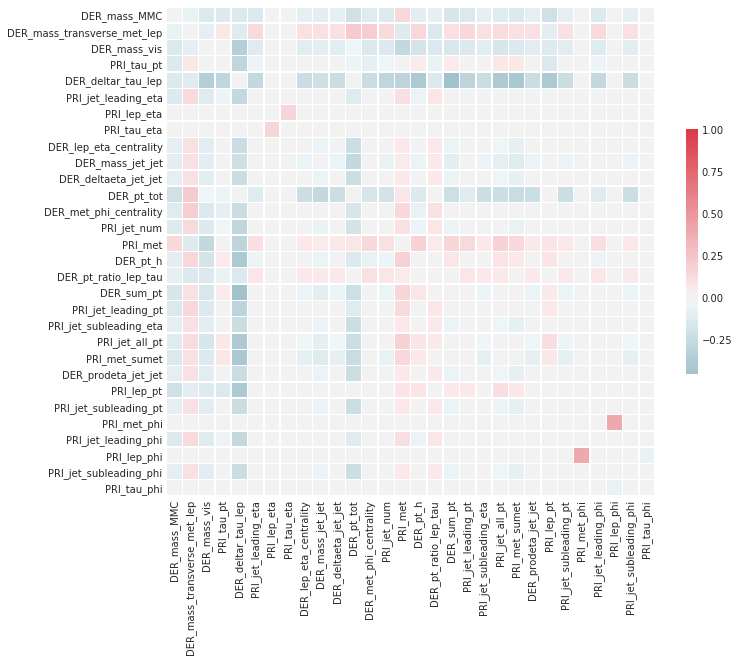

In [38]:
getCorrMat(train[sig][importantFeatures[0]], train[bkg][importantFeatures[0]])

### PCA test

In [52]:
pcaPipe, outputPipe = getPreProcPipes(normIn=True, pca=True, normPCA=True)
pcaPipe.fit(train[importantFeatures[0]].values.astype('float32'))
pcaSig = pandas.DataFrame(pcaPipe.transform(train[sig][importantFeatures[0]].values.astype('float32')))
pcaBkg = pandas.DataFrame(pcaPipe.transform(train[bkg][importantFeatures[0]].values.astype('float32')))

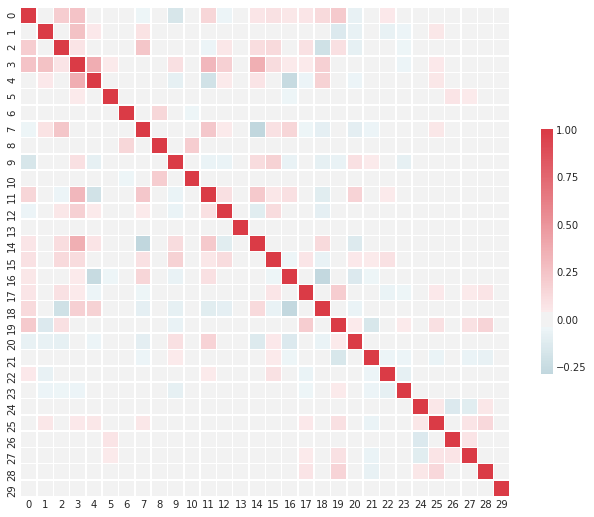

In [42]:
getCorrMat(pcaSig)

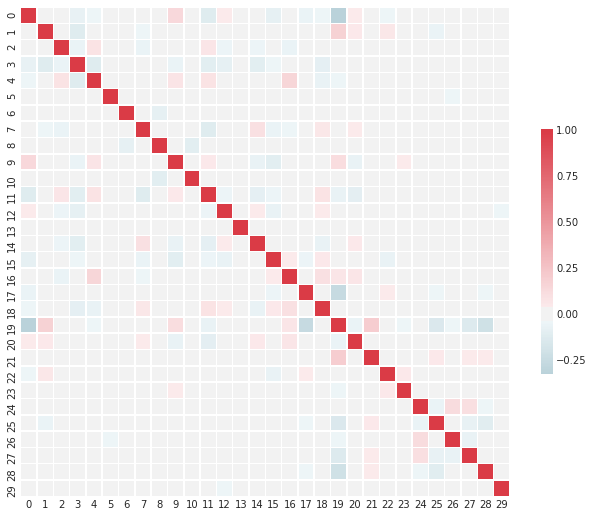

In [43]:
getCorrMat(pcaBkg)

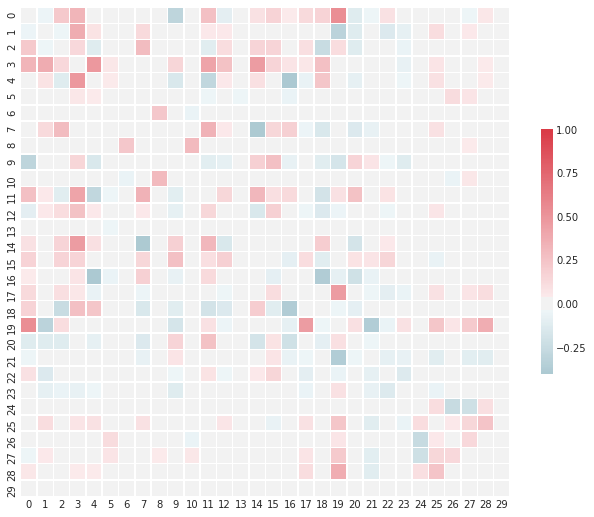

In [44]:
getCorrMat(pcaSig, pcaBkg)

### Check PCA

In [53]:
xgCompare([train[importantFeatures[0]],
           pcaPipe.transform(train[importantFeatures[0]].values.astype('float32'))],
          [train['gen_target'],
           train['gen_target']])

Dataset 0, train:test ROC AUC 0.90164:0.89828
Dataset 1, train:test ROC AUC 0.90131:0.89935


## Pre-process data

In [69]:
inputPipe, outputPipe = getPreProcPipes(normIn=True)
inputPipe.fit(train[importantFeatures[0]].values.astype('float32'))

Pipeline(memory=None,
     steps=[('normIn', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [79]:
classTrainFeatures =importantFeatures[0]

In [93]:
def saveBatch(inData, n, inputPipe, outFile):
    X = inputPipe.transform(inData[classTrainFeatures].values.astype('float32'))
    X_weights = inData['gen_weight'].values.astype('float32')
    y = inData['gen_target'].values.astype('int')
    
    grp = outFile.create_group('fold_' + str(n))
    
    inputs = grp.create_dataset("inputs", shape=X.shape, dtype='float32')
    inputs[...] = X
    
    targets = grp.create_dataset("targets", shape=y.shape, dtype='int')
    targets[...] = y
    
    weights = grp.create_dataset("weights", shape=y.shape, dtype='float32')
    weights[...] = X_weights

In [96]:
def prepareSample(inData, mode, inputPipe, N=10):
    print "Running", mode
    os.system('rm ' + dirLoc + mode + '.hdf5')
    outFile = h5py.File(dirLoc + mode + '.hdf5', "w")
            
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])

    for i, (train, test) in enumerate(folds):
        print "Saving fold:", i, "of", len(test), "events"
        saveBatch(inData.iloc[test], i, inputPipe, outFile)

In [97]:
prepareSample(train, 'train', inputPipe)
prepareSample(val, 'val', inputPipe)

Running train
Saving fold: 0 of 20001 events
Saving fold: 1 of 20001 events
Saving fold: 2 of 20001 events
Saving fold: 3 of 20000 events
Saving fold: 4 of 20000 events
Saving fold: 5 of 20000 events
Saving fold: 6 of 20000 events
Saving fold: 7 of 19999 events
Saving fold: 8 of 19999 events
Saving fold: 9 of 19999 events
Running val
Saving fold: 0 of 5000 events
Saving fold: 1 of 5000 events
Saving fold: 2 of 5000 events
Saving fold: 3 of 5000 events
Saving fold: 4 of 5000 events
Saving fold: 5 of 5000 events
Saving fold: 6 of 5000 events
Saving fold: 7 of 5000 events
Saving fold: 8 of 5000 events
Saving fold: 9 of 5000 events
